In [1]:
import torch; torch.manual_seed(0)
import torchvision as tv
import matplotlib.pyplot as plt
import numpy as np

Downloading the dataset


In [2]:
my_transforms = tv.transforms.Compose([
  tv.transforms.RandomRotation(5),
  tv.transforms.ToTensor(),
  tv.transforms.Normalize((0.1307,),(0.3081,))
])

train_dataset = tv.datasets.MNIST(
    './train',
    train=True,
    download=True,
    transform=my_transforms
)

val_dataset = tv.datasets.MNIST(
    './eval',
    train=False,
    download=True,
    transform=my_transforms
)

100%|██████████| 9912422/9912422 [00:00<00:00, 331240977.13it/s]

Extracting ./train/MNIST/raw/train-images-idx3-ubyte.gz to ./train/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 15164708.79it/s]


Extracting ./train/MNIST/raw/train-labels-idx1-ubyte.gz to ./train/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 132849732.92it/s]


Extracting ./train/MNIST/raw/t10k-images-idx3-ubyte.gz to ./train/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18265128.25it/s]

Extracting ./train/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./train/MNIST/raw



100%|██████████| 9912422/9912422 [00:00<00:00, 468453439.90it/s]


Extracting ./eval/MNIST/raw/train-images-idx3-ubyte.gz to ./eval/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 49483535.06it/s]


Extracting ./eval/MNIST/raw/train-labels-idx1-ubyte.gz to ./eval/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 187392060.82it/s]


Extracting ./eval/MNIST/raw/t10k-images-idx3-ubyte.gz to ./eval/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17704952.39it/s]

Extracting ./eval/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./eval/MNIST/raw



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=batch_size)


Visualizing the data

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


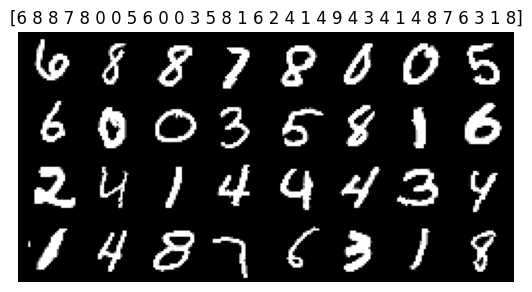

In [5]:
for images, labels in train_loader:
  grid = tv.utils.make_grid(images)
  plt.imshow(grid.numpy().transpose((1,2,0)))
  plt.title(labels.numpy())
  plt.axis('off')
  plt.show()

  break;

Defining the model and object function

In [6]:
class DigitRecNet(torch.nn.Module):
  def __init__(self, hidden_size1, hidden_size2):
    super(DigitRecNet, self).__init__()
    self.linear1 = torch.nn.Linear(28 * 28, hidden_size1)
    self.relu1 = torch.nn.ReLU()
    self.linear2 = torch.nn.Linear(hidden_size1, hidden_size2)
    self.relu2 = torch.nn.ReLU()
    self.output = torch.nn.Linear(hidden_size2, 10)

  def forward(self, x):
    out = self.linear1(x)
    out = self.relu1(out)
    out = self.linear2(out)
    out = self.relu2(out)
    out = self.output(out)

    return out

Defining the optimizer that we use to classify our loss function.

In [7]:
n_epochs = 10
learning_rate = 0.001

model = DigitRecNet(128,128)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
criterion = torch.nn.CrossEntropyLoss()

In [8]:
if torch.cuda.is_available():
  print('cuda is avialable start using gpu')
  device = torch.device('cuda')
else:
  print('cuda isn\'t avialable start using cpu')
  device = torch.device('cpu')

cuda isn't avialable start using cpu


Traing and evaluating

In [9]:
model = model.to(device)
losses = []

for epoch in range(n_epochs):
  running_loss = 0

  for images, labels in train_loader:
    images = images.reshape(-1, 28 * 28).to(device)
    labels = labels.to(device)

    output = model(images)
    loss = criterion(output, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item() * images.size(0)

  losses.append(running_loss / len(train_loader))
  print(f'Epoch {epoch + 1}/{n_epochs}: {losses[-1]:.4f}')

Epoch 1/10: 58.8761
Epoch 2/10: 25.0102
Epoch 3/10: 15.7965
Epoch 4/10: 12.9573
Epoch 5/10: 11.6306
Epoch 6/10: 10.7940
Epoch 7/10: 10.1896
Epoch 8/10: 9.7378
Epoch 9/10: 9.3575
Epoch 10/10: 8.9605


Loss as a function of epochs

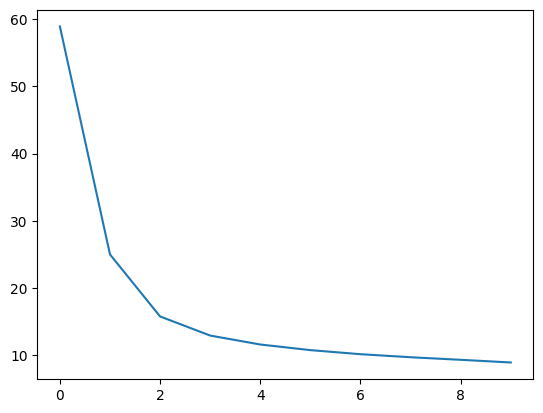

In [10]:
plt.plot(losses)
plt.show()

Testing the dataset

In [11]:
with torch.no_grad(): #After we finshed training we don't update the grad anymore
    correct_preds = 0
    total_preds = 0
    for images, labels in val_loader:
        images = images.reshape(-1, 28 * 28).to(device)
        labels = labels.to(device)

        output = model(images)
        _, preds = torch.max(output.data, 1)

        total_preds += labels.size(0)
        correct_preds += (preds == labels).sum().item()

    print(f'Accuracy: {100 * correct_preds / total_preds}%')

Accuracy: 92.44%


Visualizing some predictions

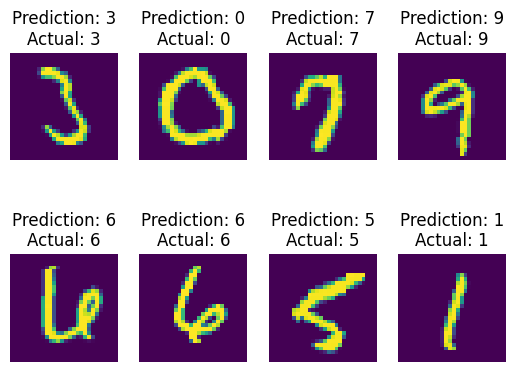

In [12]:
import random

n_images = 8

with torch.no_grad():
    for i in range(n_images):
        plt.subplot(2, n_images // 2, i + 1)
        index = random.randint(0, total_preds - 1)
        img, label = val_dataset[index]

        temp_img = img.reshape(-1, 28 * 28).to(device)
        output = model(temp_img)
        _, pred = torch.max(output.data, 1)

        plt.imshow(img.squeeze(0).numpy())
        plt.title(f'Prediction: {pred.item()}\nActual: {label}')
        plt.axis('off')

    plt.show()